In [23]:
import xarray as xr
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import warnings
import scipy.stats as sc

In [24]:
#Here, the file headers, start year, and end year are set.
#fileheader depends on where you store your files, and what the name is.
#File paths should be of the form:
#{fileheader}east_ETCs_{k}.pkl

#fileheader = "eastCoast/"
fileheader = "ECERA5/ERA5_ERA5ar_"
startyr = 1950
endyr = 2022

In [25]:
#A quick datetime function
def dt(df):
    return datetime(int(df['year']), int(df['month']), int(df['day']))

In [26]:
np.set_printoptions(suppress=True)

#Save ENSO, PDO data and create a datetime column
amo = pd.read_csv("amo.csv")
amo = amo.set_index('Year')

In [27]:
#Storm Months: Quantify how many storms are in each month
storm_months = np.zeros((13))

#ENSO Bomb: Quantify how many storms in each month in El Nino, Neutral, La Nina
#Stats are ETC/30 days, Bomb Cyclone/30 Days, Percent ETCs that become Bomb Cyclones
enso_bomb = np.zeros((13,3,3))

#AMO Bomb: two states are AMO+, AMO-
amo_bomb = np.zeros((13,2,3))

#Counting how many storms are in Southeast, Northeast
southeast = 0
northeast = 0

#Classifying storms by Southeast/Northeast, El Nino, Neutral, La Nina,
#and ETC/30 days, Bomb Cyclone/30 Days, Percent ETCs that become Bomb Cyclones
#3 dims, like the other arrays.
enso_bregion = np.zeros((2,3,3))
for k in range(startyr, endyr + 1):
    with open(f"{fileheader}east_ETCs_{k}.pkl", 'rb') as f:
        ETC = pickle.load(f)

    for storm in ETC:
        start_day = (storm['start_time'] - timedelta(hours=storm['start_time'].hour))
        amo_val = float(amo[str(start_day.month)][start_day.year])
        sb = storm['bomb']
        storm_months[start_day.month] += 1

        if (amo_val > 0):
            if sb:
                amo_bomb[start_day.month,0,1] += 1
            amo_bomb[start_day.month,0,0] += 1
        else:
            if sb:
                amo_bomb[start_day.month,1,1] += 1
            amo_bomb[start_day.month,1,0] += 1    

#Get bombogenesis fraction by dividing BCs by ETCs
amo_bomb[1:13,:,2] = amo_bomb[1:13,:,1] / amo_bomb[1:13,:,0]

amo_bomb_raw = np.copy(amo_bomb)

#get the number of months in each AMO state, by month of the year (Jan, Feb, ..., Dec)
amo_states_bymonth = np.zeros((13,2))
for y in range(startyr,endyr+1):
    for i in range(1,13):
        val = float(amo[str(i)][y])
        if (val >= 0):
            amo_states_bymonth[i, 0] += 1
        else:
            amo_states_bymonth[i, 1] += 1

#divides by this value to get storms per 30 days per AMO state
for i in range(1,13):
    amo_bomb[i,0,0:2] = amo_bomb[i,0,0:2] / amo_states_bymonth[i, 0]
    amo_bomb[i,1,0:2] = amo_bomb[i,1,0:2] / amo_states_bymonth[i, 1]

In [28]:
#make winter the months in the middle
months = ["July","August","September","October", "November", "December", "January", "February", "March","April","May","June"]
amow = np.concatenate((amo_bomb[7:13], amo_bomb[1:7]))

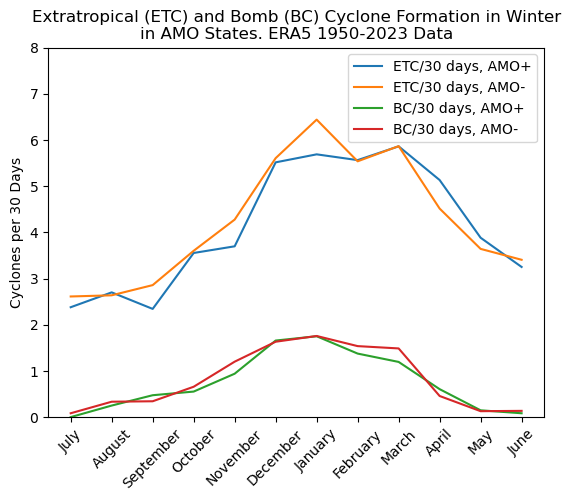

In [29]:
#Plot results
plt.plot(months, amow[:,0,0], label="ETC/30 days, AMO+")
plt.plot(months, amow[:,1,0], label="ETC/30 days, AMO-")

plt.plot(months, amow[:,0,1], label="BC/30 days, AMO+")
plt.plot(months, amow[:,1,1], label="BC/30 days, AMO-")
plt.legend()

plt.xticks(months, rotation=45)
plt.ylabel("Cyclones per 30 Days")
plt.ylim((0,8))
plt.title("Extratropical (ETC) and Bomb (BC) Cyclone Formation in Winter\nin AMO States. ERA5 1950-2023 Data")
plt.savefig("figures/AMO_ETC_BC_ERA5.png")

In [50]:
#EXTRATROPICAL CYCLONE BLOCK
#Prepare to do chi-square tests: number of ETCs in each state (rounded)
#vs expected number of ETCs in each state (based on time fraction)
#months = (10,11,12,1,2,3)
months = (12,1,2)
amo_analysis = np.array([[amo_states_bymonth[months,0].sum() * 30,amo_states_bymonth[months,1].sum() * 30],
                       [amo_bomb_raw[months,0,0].sum(), amo_bomb_raw[months,1,0].sum()]])
amo_analysis[0] = np.round(amo_analysis[0] / amo_analysis[0].sum() * amo_analysis[1].sum())


In [51]:
#EXTRATROPICAL CYCLONE CHI-SQUARE TEST
print("AMO",sc.chisquare(amo_analysis[1], amo_analysis[0]))

AMO Power_divergenceResult(statistic=np.float64(0.7226869927839898), pvalue=np.float64(0.3952639387452648))


In [52]:
#BOMB CYCLONE BLOCK
#Prepare to do chi-square tests: number of ETCs in each state (rounded)
#vs expected number of ETCs in each state (based on time fraction)
amo_analysis = np.array([[amo_states_bymonth[months,0].sum() * 30,amo_states_bymonth[months,1].sum() * 30],
                       [amo_bomb_raw[months,0,1].sum(), amo_bomb_raw[months,1,1].sum()]])
amo_analysis[0] = np.round(amo_analysis[0] / amo_analysis[0].sum() * amo_analysis[1].sum())


In [53]:
#BOMB CYCLONE CHI-SQUARE TEST
print("AMO",sc.chisquare(amo_analysis[1], amo_analysis[0]))

AMO Power_divergenceResult(statistic=np.float64(0.04551282051282052), pvalue=np.float64(0.8310638509832039))
